In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import seaborn as sns

In [17]:
# setup
file_path = "all_result_v1.pkl"
performance_col_name = "low1000_1"
quality_col_name = "psnr"
quality_threshold = 15

In [18]:
aggregate_attack_name_dict = {
    "Distortion Single": [
        "distortion_single_rotation",
        "distortion_single_resizedcrop",
        "distortion_single_erasing",
        "distortion_single_brightness",
        "distortion_single_contrast",
        "distortion_single_blurring",
        "distortion_single_noise",
        "distortion_single_jpeg",
    ],
    "Distortion Combination": [
        "distortion_combo_geometric",
        "distortion_combo_photometric",
        "distortion_combo_degradation",
        "distortion_combo_all",
    ],
    "Regeneration Single": ["regen_diffusion", "kl_vae"],
    "Regeneration Rinsing": ["2x_regen", "4x_regen"],
    "Adv Embedding Gray-box": ["adv_emb_same_vae_untg"],
    "Adv Embedding Black-box": [
        "adv_emb_clip_untg_alphaRatio_0.05_step_200",
        "adv_emb_sdxl_vae_untg",
        "adv_emb_klf16_vae_untg",
    ],
    "Adv Surrogate Detector": ["adv_cls_wm1_wm2_0.01_50_warm"],
}

In [19]:
df = pd.read_pickle(file_path)
df

,eval_setup,dataset_name,source_name,attack_name,attack_strength,acc_1,auc_1,low100_1,low1000_1,legacy_fid,clip_fid,psnr,ssim,nmi,lpips,watson,aesthetics,artifacts,clip_score
0,removal,dalle3,stable_sig,4x_regen_kl_vae,8.0,0.5001,0.360216,0.0016,0.0004,"(46.12348781608932, 0.0)","(8.992265823301551, 0.0)","(17.199796537364293, 2.269189505607515)","(0.39733862463659614, 0.09261186435461086)","(1.0911852889505835, 0.031366562294090135)","(0.4905354205071926, 0.10838788701403224)","(6491883.1755, 13013495.7750652)","(1.281013566672802, 0.8179406189703678)","(-0.4907000326514244, 0.40590312896105485)","(-0.02172722030710429, 0.019664222858970473)"
1,removal,dalle3,stable_sig,adv_emb_clip_untg_alphaRatio_0.05_step_200,2.0,0.9984,0.999695,0.9980,0.9972,"(1.5416575532917705, 0.0)","(25.287483213360108, 3.552713678800501e-15)","(43.71427362464086, 0.3420215417855504)","(0.9867237320919474, 0.005671492383389793)","(1.6133441606600623, 0.020300613091421078)","(0.008419898152875247, 0.008218121675276056)","(437109.038390625, 3971476.2536129635)","(0.15220061630010606, 0.24954178237096644)","(-0.05379353821277619, 0.12816892088923812)","(-0.0012738871546462177, 0.006560638785684172)"
2,removal,dalle3,stable_sig,2x_regen,20.0,0.5298,0.537489,0.0098,0.0018,"(4.808336591091461, 0.0)","(0.38104822151503015, 0.0)","(23.249902572912536, 3.1788729755903278)","(0.6833927196897406, 0.10811329418038841)","(1.187487968029458, 0.059042823517310404)","(0.12361973528191447, 0.04310015426425451)","(3685886.7109375, 35441197.346991636)","(0.0821058354973793, 0.3396569703025583)","(0.015196512311697006, 0.1788275712807598)","(-0.0010460978876799345, 0.008120075928693423)"
3,removal,dalle3,stable_sig,adv_cls_real_wm_0.01_50_warm,8.0,0.9980,0.999471,0.9980,0.9964,"(0.7113836169586989, 0.0)","(0.22029766436683929, 0.0)","(42.31186376428473, 1.8866201639732538)","(0.983585539693678, 0.00516051468205318)","(1.558867287817048, 0.043258092467638884)","(0.010971170436474494, 0.008905676611333534)","(538782.2018359374, 7158327.205991846)","(0.031158906877040864, 0.16183392432548427)","(0.0009671718478202819, 0.09072956191395361)","(-0.00048506836034357547, 0.004469317320971539)"
4,removal,dalle3,stable_sig,adv_cls_real_wm_0.01_50_warm,6.0,0.9981,0.999578,0.9980,0.9966,"(0.47755575898213465, 0.0)","(0.14674711078012592, 0.0)","(43.936693335794004, 1.3308611051112806)","(0.9882749988797969, 0.0037089530882295657)","(1.6020914021720603, 0.030189437035218994)","(0.007419525931501994, 0.0066372411923751595)","(362634.86104296875, 3523992.446032149)","(0.02350645011663437, 0.1415184981726149)","(0.0008609980940818787, 0.08250103754400105)","(-0.00015730367321521043, 0.003923573073218316)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,combined,mscoco,tree_ring,regen_diffusion_prompt,160.0,0.9619,0.993320,0.9006,0.7336,"(8.586375371709012, 1.4043333874306805e-15)","(1.9254719088750103, 3.510833468576701e-16)","(21.71826298577528, 2.872949031655825)","(0.6279947179276391, 0.12845373357061987)","(1.1643855177796882, 0.05076783329707679)","(0.17630047589819878, 0.04575402362679158)","(8850697.016785156, 329854881.56977266)","(0.48193047654628757, 0.5125005902952873)","(-0.284070571795106, 0.2799417479842635)","(-0.0009336986921261996, 0.010856786538976055)"
3455,combined,mscoco,tree_ring,regen_vae,5.0,0.9984,0.999987,0.9996,0.9974,"(6.674961939260414, 1.2560739669470201e-15)","(2.0396622313477053, 3.1401849173675503e-16)","(33.22537572641761, 2.76863357625072)","(0.9219745583493202, 0.033548934866993715)","(1.3692031110431717, 0.06330696905678053)","(0.09298591066687367, 0.0522560009264153)","(549703.8531171875, 392775.0001276065)","(0.24785685396194457, 0.3224470661981921)","(-0.19860438038408756, 0.20142869003351288)","(-0.00596388701943215, 0.008134300972922613)"
3456,combined,mscoco,tree_ring,regen_diffusion_prompt,80.0,0.9829,0.998044,0.9742,0.9206,"(6.597553532255489, 6.280369834735101e-16)","(1.3471922281754232, 1.570092458683775

# select data


In [20]:
columns = [
    "dataset_name",
    "source_name",
    "attack_name",
    "attack_strength",
    performance_col_name,
    quality_col_name,
]

In [21]:
data = df[(df["eval_setup"] == "removal")][columns]

In [22]:
# change tuple to number, only keep mean (option)
data["psnr"] = data["psnr"].apply(lambda x: x[0] if pd.notnull(x) else x)

In [23]:
data

,dataset_name,source_name,attack_name,attack_strength,low1000_1,psnr
0,dalle3,stable_sig,4x_regen_kl_vae,8.0,0.0004,17.199797
1,dalle3,stable_sig,adv_emb_clip_untg_alphaRatio_0.05_step_200,2.0,0.9972,43.714274
2,dalle3,stable_sig,2x_regen,20.0,0.0018,23.249903
3,dalle3,stable_sig,adv_cls_real_wm_0.01_50_warm,8.0,0.9964,42.311864
4,dalle3,stable_sig,adv_cls_real_wm_0.01_50_warm,6.0,0.9966,43.936693
...,...,...,...,...,...,...
1153,mscoco,tree_ring,regen_diffusion_prompt,120.0,0.5598,22.106440
1158,mscoco,tree_ring,regen_vae,7.0,0.9998,37.056776
1159,mscoco,tree_ring,regen_vae,1.0,0.4224,26.959218
1160,mscoco,tree_ring,regen_vae,3.0,0.8794,29.858860


In [24]:
# only keep datapoints that have quality larger than the threshold
data = data[data[quality_col_name] > quality_threshold]

In [25]:
data

,dataset_name,source_name,attack_name,attack_strength,low1000_1,psnr
0,dalle3,stable_sig,4x_regen_kl_vae,8.0,0.0004,17.199797
1,dalle3,stable_sig,adv_emb_clip_untg_alphaRatio_0.05_step_200,2.0,0.9972,43.714274
2,dalle3,stable_sig,2x_regen,20.0,0.0018,23.249903
3,dalle3,stable_sig,adv_cls_real_wm_0.01_50_warm,8.0,0.9964,42.311864
4,dalle3,stable_sig,adv_cls_real_wm_0.01_50_warm,6.0,0.9966,43.936693
...,...,...,...,...,...,...
1153,mscoco,tree_ring,regen_diffusion_prompt,120.0,0.5598,22.106440
1158,mscoco,tree_ring,regen_vae,7.0,0.9998,37.056776
1159,mscoco,tree_ring,regen_vae,1.0,0.4224,26.959218
1160,mscoco,tree_ring,regen_vae,3.0,0.8794,29.858860


# aggregate attacks


In [26]:
data_copy = data.copy()

# Invert the dictionary for easy mapping
attack_name_to_aggregate = {
    v: k for k, vals in aggregate_attack_name_dict.items() for v in vals
}

# Map each attack_name to its aggregate category
data_copy["aggregate_category"] = data_copy["attack_name"].map(attack_name_to_aggregate)

# Filter out rows where attack_name does not belong to any aggregate category
data_filtered = data_copy[data_copy["aggregate_category"].notna()]

In [27]:
data_filtered

,dataset_name,source_name,attack_name,attack_strength,low1000_1,psnr,aggregate_category
1,dalle3,stable_sig,adv_emb_clip_untg_alphaRatio_0.05_step_200,2.0,0.9972,43.714274,Adv Embedding Black-box
2,dalle3,stable_sig,2x_regen,20.0,0.0018,23.249903,Regeneration Rinsing
5,dalle3,stable_sig,2x_regen,80.0,0.0004,20.932714,Regeneration Rinsing
6,dalle3,stable_sig,adv_emb_clip_untg_alphaRatio_0.05_step_200,4.0,0.9970,38.355332,Adv Embedding Black-box
7,dalle3,stable_sig,4x_regen,30.0,0.0002,19.654007,Regeneration Rinsing
...,...,...,...,...,...,...,...
1142,mscoco,tree_ring,kl_vae,8.0,1.0000,27.250314,Regeneration Single
1143,mscoco,tree_ring,regen_diffusion,120.0,0.6170,22.230475,Regeneration Single
1144,mscoco,tree_ring,regen_diffusion,160.0,0.4822,21.559631,Regeneration Single
1147,mscoco,tree_ring,kl_vae,32.0,0.9820,23.341799,Regeneration Single


# prepare data for radar plot


In [28]:
# mean performance
agg_performance_data = (
    data_filtered.groupby(["source_name", "aggregate_category"])[performance_col_name]
    .mean()
    .reset_index()
)

In [29]:
agg_performance_data

,source_name,aggregate_category,low1000_1
0,stable_sig,Adv Embedding Black-box,0.998056
1,stable_sig,Adv Embedding Gray-box,0.998017
2,stable_sig,Adv Surrogate Detector,0.998533
3,stable_sig,Distortion Combination,0.605279
4,stable_sig,Distortion Single,0.731880
5,stable_sig,Regeneration Rinsing,0.000340
6,stable_sig,Regeneration Single,0.097052
7,stegastamp,Adv Embedding Black-box,1.000000
8,stegastamp,Adv Embedding Gray-box,1.000000
9,stegastamp,Adv Surrogate Detector,1.000000


# draw radar plot


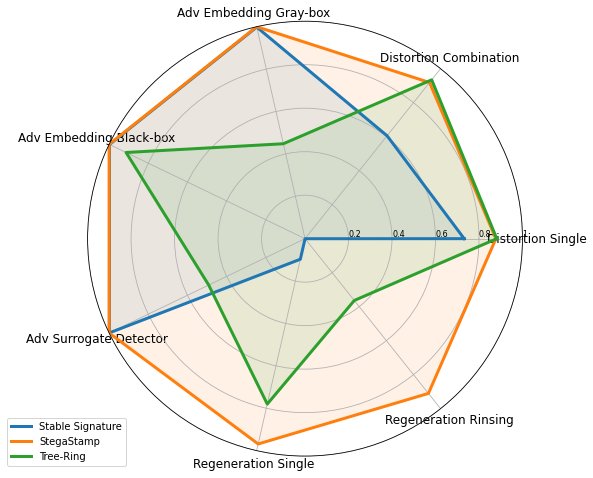

In [39]:
# Pivot the DataFrame
pivoted_df = agg_performance_data.pivot(
    index="aggregate_category", columns="source_name", values=performance_col_name
)

attack_order = [
    "Distortion Single",
    "Distortion Combination",
    "Adv Embedding Gray-box",
    "Adv Embedding Black-box",
    "Adv Surrogate Detector",
    "Regeneration Single",
    "Regeneration Rinsing",
]


# Reindex the pivoted DataFrame according to the desired order
pivoted_df = pivoted_df.reindex(attack_order)


# Get the attack categories
categories = list(pivoted_df.index)
N = len(categories)

# Prepare data for radar chart
values = pivoted_df.reset_index(drop=True).T.values.tolist()
values = [value + value[:1] for value in values]

# Number of variables (attacks), we plot one angle per category
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialize the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot and fill for each source
wms = ["Stable Signature", "StegaStamp", "Tree-Ring"]
for idx, value in enumerate(values):
    ax.plot(angles, value, linewidth=3, linestyle="solid", label=wms[idx])
    ax.fill(angles, value, alpha=0.1)

# Draw one axe per attack category and add labels
plt.xticks(angles[:-1], categories, color="black", size=12)
# plt.xticks(angles, [""] * len(angles))  # set labels to empty!

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks(
    [0.2, 0.4, 0.6, 0.8, 1], ["0.2", "0.4", "0.6", "0.8", "1"], color="black", size=8
)
plt.ylim(0, 1)


# Add a legend
plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))

plt.show()

# prepare data for violin plot


In [40]:
data_filtered

,dataset_name,source_name,attack_name,attack_strength,low1000_1,psnr,aggregate_category
1,dalle3,stable_sig,adv_emb_clip_untg_alphaRatio_0.05_step_200,2.0,0.9972,43.714274,Adv Embedding Black-box
2,dalle3,stable_sig,2x_regen,20.0,0.0018,23.249903,Regeneration Rinsing
5,dalle3,stable_sig,2x_regen,80.0,0.0004,20.932714,Regeneration Rinsing
6,dalle3,stable_sig,adv_emb_clip_untg_alphaRatio_0.05_step_200,4.0,0.9970,38.355332,Adv Embedding Black-box
7,dalle3,stable_sig,4x_regen,30.0,0.0002,19.654007,Regeneration Rinsing
...,...,...,...,...,...,...,...
1142,mscoco,tree_ring,kl_vae,8.0,1.0000,27.250314,Regeneration Single
1143,mscoco,tree_ring,regen_diffusion,120.0,0.6170,22.230475,Regeneration Single
1144,mscoco,tree_ring,regen_diffusion,160.0,0.4822,21.559631,Regeneration Single
1147,mscoco,tree_ring,kl_vae,32.0,0.9820,23.341799,Regeneration Single


In [41]:
agg_quality_data = (
    data_filtered.groupby("aggregate_category")[quality_col_name]
    .apply(list)
    .reset_index()
)

In [42]:
agg_quality_data

,aggregate_category,psnr
0,Adv Embedding Black-box,"[43.71427362464086, 38.355332029685435, 36.872..."
1,Adv Embedding Gray-box,"[42.70812178423499, 37.06332829590075, 33.8375..."
2,Adv Surrogate Detector,"[47.0196636419593, 50.99757591106392, 44.67493..."
3,Distortion Combination,"[19.729689360206372, 22.794649364626334, 20.87..."
4,Distortion Single,"[19.999860247323014, 18.318453099214743, 21.80..."
5,Regeneration Rinsing,"[23.249902572912536, 20.932713699145907, 19.65..."
6,Regeneration Single,"[29.273243119982357, 26.591185229301715, 25.74..."


In [43]:
# Explode the 'psnr' lists into separate rows
agg_quality_data = agg_quality_data.explode(quality_col_name)

# Convert 'psnr' to numeric
agg_quality_data[quality_col_name] = pd.to_numeric(agg_quality_data[quality_col_name])

In [44]:
agg_quality_data

,aggregate_category,psnr
0,Adv Embedding Black-box,43.714274
0,Adv Embedding Black-box,38.355332
0,Adv Embedding Black-box,36.872482
0,Adv Embedding Black-box,35.279709
0,Adv Embedding Black-box,33.011020
...,...,...
6,Regeneration Single,27.250314
6,Regeneration Single,22.230475
6,Regeneration Single,21.559631
6,Regeneration Single,23.341799


# draw violin plot


In [48]:
show_order = [
    "Distortion Single",
    "Distortion Combination",
    "Regeneration Single",
    "Regeneration Rinsing",
    "Adv Embedding Gray-box",
    "Adv Embedding Black-box",
    "Adv Surrogate Detector",
]

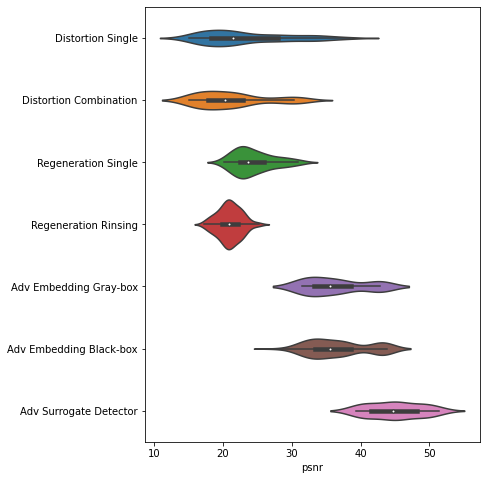

In [50]:
plt.figure(figsize=(6, 8))

# Create the violin plot with switched axes
ax = sns.violinplot(
    y="aggregate_category", x=quality_col_name, data=agg_quality_data, order=show_order
)

ax.set_ylabel("")

# Optional: Set the limits of the x-axis if you want to focus on a specific range of PSNR values
# plt.xlim([lower_limit, upper_limit])

plt.show()